# 6-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

이전 스텝까지는 영문 텍스트의 감정 분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정 분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)입니다.

데이터 다운로드 없이 Cloud shell에서 해당 파일의 심볼릭 링크를 연결해 주세요

`$ ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data`

프로젝트 진행 순서는 다음과 같습니다.

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


- `['document']` : 댓글 텍스트가 담긴 시리즈
- `['label']` : 이미 x_train 데이터에서 y로 출력될 라벨이 셋팅되어 있었다. ***(하지만 어떤 기준의 라벨인지 모름)***

## 2) 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 `imdb.data_loader()` 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 `word_to_index` 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 `imdb.data_loader()`와 동일하게 동작하는 자신만의 `data_loader`를 만들어 보는 것으로 시작합니다. `data_loader` 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴



In [2]:
from konlpy.tag import Mecab # 토큰화 하는 라이브러리
import numpy as np
from collections import Counter

tokenizer = Mecab() # 토크나이저 생성 # Mecab()은 형태소를 분석에 사용된다.
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):

    train_data.drop_duplicates(subset=['document'], inplace=True)       # (1)  
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    # (1)
    # ['document']는 위의 표에서 댓글의 내용을 나타내는 시리즈(컬럼)이다.
    # duplicates() : 중복 여부 불리언 값을 시리즈로 반환한다.
    # drop.drop_dupicates() : 제거할 중복 값
    # subset = ['col']
    # keep='first' 중복 첫번째만 남기고 True를 반환, keep='last'마지막값을 제외하고 모두 True 반환
    # kepp=False 는 중복되는 모든 값을 True 반환
    # DataFrame.drop_duplicates(subset=['col'], keep='first', inplace=True)
    
    x_train = [] 
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_train.append(temp_X)

    x_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_test.append(temp_X)
    
    # x_train에 대한 라벨링 진행
    words = np.concatenate(x_train).tolist() 
    counter = Counter(words)   # (2)
    counter = counter.most_common(10000-4)  # (3)   
    # pre_vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>']  # (4)
    vocab = [key for key, _ in counter]  # (5)
    word_to_index = {word:(index+4) for index, word in enumerate(vocab)}  # (6)
    
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    word_to_index["<UNUSED>"] = 3

    # (2)
    # collections.Counter(list) : list 요소들의 갯수를 딕셔너리 형태로 반환
    # collections.Counter(list).most_common(n) : list의 요소를 세어, 최빈값 n개를 리스트에 담긴 튜플형태로 반환
    # list.most_common() : 개수가 많은 순으로 정렬된 튜플 배열 리스트를 반환

    # (3)
    # 10000에서 4를 빼는 이유 : pre_vocab의 4개를 뺀 갯수
    
    # (4)
    # 지금은 vocab과 분리 해 둔다. 후에 vocab앞에 넣어준다.
    # 사실 지금 정의해 둘 필요는 없지만 어디에 뭐가 들어갈지 너어무 헷갈려서 미리 써둠

    # (5)
    # counter에 담긴 두 쌍의 튜플값에서 단어만 가지고 온다.
    
    # (6)
    # enumerate(list) : index와 해당 요소를 반환
    # (index+3) : 후에 vocab앞에 pre_vocab을 넣어야 하므로, 인덱스 번호를 4부터 시작하게 맞춰준다.
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] for word in wordlist if word in word_to_index]   
        
    x_train = list(map(wordlist_to_indexlist, x_train)) # (7)
    x_test = list(map(wordlist_to_indexlist, x_test))

    # (7)
    # list(map(함수이름, 함수에 들어갈 인자)) : map으로 함수를 실행시켜서 list로 반환
    # map(함수이름, 함수에 들어갈 인자) = 함수이름(인자)   
    
    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))
    
    
    index_to_word = {index:word for word, index in word_to_index.items()}
        
    return x_train, y_train, x_test, y_test, word_to_index, index_to_word
            
    
x_train, y_train, x_test, y_test, word_to_index, index_to_word = load_data(train_data, test_data)

- `x_train`, `y_train`, `x_test`, `y_test`, `word_to_index`, `index_to_word`을 모두 설정했다.



In [3]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

! 매번 **list comprehension**을 사용할때 `[i for i in List if문]`의 형태로만 사용했는데, 예시코드를 보니 **`[List[i] if i in List for i in _]`**의 형태로 사용되어도 같은 결과값이 나온다는 것이 신기했다.


In [4]:
# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

In [5]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence(x_train[15], index_to_word))
print('라벨: ', y_train[15])  # 1번째 리뷰데이터의 라벨

냥 매번 긴장 되 고 재 밋 음 ㅠㅠ
라벨:  1


In [6]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
total_data_text = x_train + x_test
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 약 %.2f퍼센트가 maxlen 설정값 이내에 포함됩니다.' % (np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.26729941281567
문장길이 최대 :  116
문장길이 표준편차 :  12.314845334104783
pad_sequences maxlen :  39
전체 문장의 약 0.93퍼센트가 maxlen 설정값 이내에 포함됩니다.


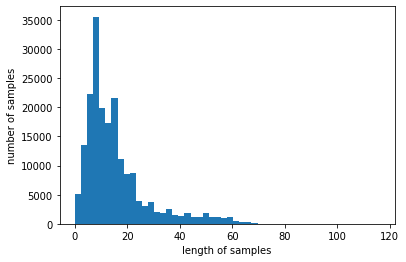

In [8]:
# 리뷰 길이 분포 확인
from matplotlib import pyplot as plt

plt.hist(num_tokens, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [9]:
import tensorflow as tf

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 39)


## 4) 모델 구성 및 validation set 구성 

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.
- validation set은 **5) 모델 학습**때에 분리할 예정이다.

In [10]:
import tensorflow as tf

### RNN 모델

In [11]:
# 임베딩사이즈는 (1, 10000, 4)이다.
# 단어사전의 갯수 10000개, 단어 하나당 4차원 벡터
# LSTM은 3차원을 입력값으로 받으므로, 3차원 배열로 임베딩 해준다.

rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Embedding(10000, 4, input_shape=(None,)))
rnn_model.add(tf.keras.layers.LSTM(28))   
rnn_model.add(tf.keras.layers.Dense(12, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40000     
_________________________________________________________________
lstm (LSTM)                  (None, 28)                3696      
_________________________________________________________________
dense (Dense)                (None, 12)                348       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 44,057
Trainable params: 44,057
Non-trainable params: 0
_________________________________________________________________


### CNN 모델

In [12]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(10000, 4, input_shape=(None,)))
cnn_model.add(tf.keras.layers.Conv1D(32, 3, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(10))
cnn_model.add(tf.keras.layers.Conv1D(32, 3, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(16, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          416       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          3104      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

전체 문장 중에서 <u>단 하나의 가장 중요한 단어만 피처로 추출</u>하여 그것으로 문장의 **긍정/부정**을 평가하는 방식

In [13]:
GMP_model = tf.keras.Sequential()
GMP_model.add(tf.keras.layers.Embedding(10000, 32, input_shape=(None,)))
GMP_model.add(tf.keras.layers.GlobalMaxPooling1D())
GMP_model.add(tf.keras.layers.Dense(8, activation='relu'))
GMP_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

GMP_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련 개시

In [14]:
print('학습용 데이터 전체 개수 :', len(x_train))
print('학습용 데이터 개수 ;', len(x_train)*0.7)
print('검증용 데이터 개수 :', len(x_train)*0.3)

학습용 데이터 전체 개수 : 146182
학습용 데이터 개수 ; 102327.4
검증용 데이터 개수 : 43854.6


- **x_train**과 **x_val**을 *7:3 비율*로 나누어서 학습과 검증을 반복하도록 설정

모델을 학습하기에 앞서, **model.compile()** 메서드를 통해서 학습방식에 대한 설정을 해야한다.
- **optimizer(정규화기)** : 최적화 알고리즘 설정
- **loss(손실함수)** : 최적화에 사용되는 목적 함수
- **metrics(평가지표)** : <u>분류에서는 accuracy</u>, 회귀에서는 mse, rmse, r2, mae, mspe, mape, msle 등을 사용

- **verbose = 학습 중 출력되는 문구를 설정**
    - 0 : 아무 것도 출력하지 않는다.
    - 1 : 훈련의 진행도를 보여주는 진행 막대를 보여준다.
    - 2 : 미니 배치마다 손실 정보를 출력한다.

In [15]:
rnn_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
rnn_history = rnn_model.fit(x_train, y_train, epochs=10, batch_size=512, validation_split=0.3, verbose=1)

Epoch 1/10
200/200 [==============================] - 5s 8ms/step - loss: 0.5605 - accuracy: 0.6699 - val_loss: 0.3997 - val_accuracy: 0.8237
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3585 - accuracy: 0.8441 - val_loss: 0.3719 - val_accuracy: 0.8344
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3281 - accuracy: 0.8607 - val_loss: 0.3696 - val_accuracy: 0.8382
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3150 - accuracy: 0.8669 - val_loss: 0.3652 - val_accuracy: 0.8409
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3068 - accuracy: 0.8713 - val_loss: 0.3640 - val_accuracy: 0.8420
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3006 - accuracy: 0.8731 - val_loss: 0.3664 - val_accuracy: 0.8412
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2957 - accuracy: 0.8761 - val_loss: 0.3667 - val_accuracy: 0.8419
Epoch 

In [16]:
cnn_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(x_train, y_train, epochs=10, batch_size=512, validation_split=0.3, verbose=1)

Epoch 1/10
200/200 [==============================] - 3s 6ms/step - loss: 0.5201 - accuracy: 0.7267 - val_loss: 0.3839 - val_accuracy: 0.8293
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3453 - accuracy: 0.8529 - val_loss: 0.3643 - val_accuracy: 0.8409
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3116 - accuracy: 0.8698 - val_loss: 0.3622 - val_accuracy: 0.8434
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2907 - accuracy: 0.8798 - val_loss: 0.3633 - val_accuracy: 0.8438
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2748 - accuracy: 0.8874 - val_loss: 0.3719 - val_accuracy: 0.8433
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2598 - accuracy: 0.8945 - val_loss: 0.3832 - val_accuracy: 0.8411
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2471 - accuracy: 0.9013 - val_loss: 0.4016 - val_accuracy: 0.8368
Epoch 

In [17]:
GMP_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
GMP_history = GMP_model.fit(x_train, y_train, epochs=10, batch_size=512, validation_split=0.3, verbose=1)

Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5672 - accuracy: 0.7536 - val_loss: 0.4170 - val_accuracy: 0.8198
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3595 - accuracy: 0.8457 - val_loss: 0.3605 - val_accuracy: 0.8403
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3060 - accuracy: 0.8722 - val_loss: 0.3513 - val_accuracy: 0.8471
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2734 - accuracy: 0.8886 - val_loss: 0.3539 - val_accuracy: 0.8476
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2477 - accuracy: 0.9015 - val_loss: 0.3626 - val_accuracy: 0.8464
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2253 - accuracy: 0.9116 - val_loss: 0.3745 - val_accuracy: 0.8453
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2053 - accuracy: 0.9212 - val_loss: 0.3898 - val_accuracy: 0.8435
Epoch 

## 6) Loss, Accuracy 그래프 시각화

### RNN

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


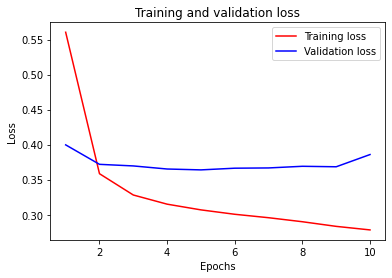

In [18]:
rnn_history_dict = rnn_history.history
print(rnn_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = rnn_history_dict['accuracy']
val_acc = rnn_history_dict['val_accuracy']
loss = rnn_history_dict['loss']
val_loss = rnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 오버피팅이 일어났다...

### CNN

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


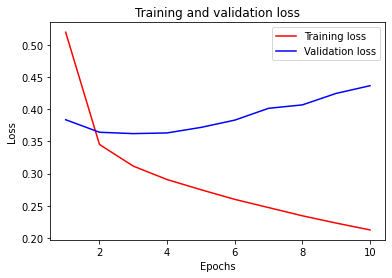

In [19]:
cnn_history_dict = cnn_history.history
print(cnn_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = cnn_history_dict['accuracy']
val_acc = cnn_history_dict['val_accuracy']
loss = cnn_history_dict['loss']
val_loss = cnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 또 오버피팅...^^

### GlobalMaxPooling1D()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


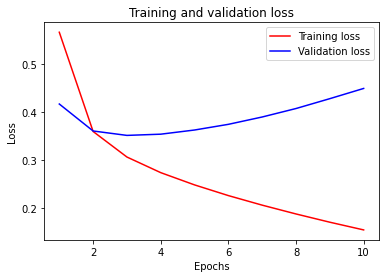

In [20]:
GMP_history_dict = GMP_history.history
print(GMP_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = GMP_history_dict['accuracy']
val_acc = GMP_history_dict['val_accuracy']
loss = GMP_history_dict['loss']
val_loss = GMP_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 또 또 오버피팅...

In [21]:
results_1 = rnn_model.evaluate(x_test,  y_test, verbose=2)
results_2 = cnn_model.evaluate(x_test,  y_test, verbose=2)
results_3 = GMP_model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.3895 - accuracy: 0.8356
1537/1537 - 3s - loss: 0.4343 - accuracy: 0.8327
1537/1537 - 2s - loss: 0.4547 - accuracy: 0.8342


## 7) 학습된 Embedding 레이어 분석

```
$ mkdir -p ~/aiffel/sentiment_classification/data
$ pip list | grep gensim
```

### RNN

In [22]:
rnn_embedding_layer = rnn_model.layers[0]
rnn_weights = rnn_embedding_layer.get_weights()[0]

# shape: (vocab_size, embedding_dim)
print(rnn_weights.shape)    

(10000, 4)


In [23]:
import os

vocab_size = rnn_weights.shape[0]
rnn_word_vector_dim = rnn_weights.shape[1]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, rnn_word_vector_dim))

7

In [24]:
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
rnn_vectors = rnn_model.get_weights()[0]

for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(rnn_vectors[i, :])))))
f.close()

### CNN

In [25]:
cnn_embedding_layer = cnn_model.layers[0]
cnn_weights = cnn_embedding_layer.get_weights()[0]

# shape: (vocab_size, embedding_dim)
print(cnn_weights.shape)    

(10000, 4)


In [26]:
vocab_size = rnn_weights.shape[0]
cnn_word_vector_dim = cnn_weights.shape[1]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')

In [27]:
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
cnn_vectors = cnn_model.get_weights()[0]

for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(cnn_vectors[i, :])))))
f.close()

### GlobalMaxPooling1D()

In [28]:
GMP_embedding_layer = GMP_model.layers[0]
GMP_weights = GMP_embedding_layer.get_weights()[0]

# shape: (vocab_size, embedding_dim)
print(GMP_weights.shape)    

(10000, 32)


In [29]:
vocab_size = GMP_weights.shape[0]
GMP_word_vector_dim = GMP_weights.shape[1]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')

In [30]:
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
GMP_vectors = GMP_model.get_weights()[0]

for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(GMP_vectors[i, :])))))
f.close()

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선 

한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

- [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)

위 링크에서 적절한 ko.bin을 찾아 이용하세요. 그리고 gensim 버전을 3.x.x로 낮춰야 오류가 나지 않습니다.

In [31]:
pip freeze

absl-py==0.12.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1637087032947/work
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1636093929600/work
albumentations==1.1.0
antlr4-python3-runtime==4.8
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1637703202493/work/dist
appdirs==1.4.4
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1636021379509/work
astunparse==1.6.3
async-generator==1.10
async-timeout @ file:///home/conda/feedstock_root/build_artifacts/async-timeout_1637092647930/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1620387926260/work
audioread==2.1.9
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1618230623929/work
beautifulsoup4==4.6.0
black==21.12b0
bleach @ file:///home/conda/feedstock_root/build_artifacts/ble

In [32]:
!pip uninstall gensim --yes
!pip install gensim==3.8.3

Found existing installation: gensim 3.8.3
Uninstalling gensim-3.8.3:
  Successfully uninstalled gensim-3.8.3
  Using cached gensim-3.8.3-cp39-cp39-linux_x86_64.whl


In [34]:
import os
from gensim.models import Word2Vec

### RNN

In [35]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec =Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector  # 200dim의 워드 벡터입니다.

/tmp/ipykernel_968/2704449283.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [36]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_968/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [37]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_968/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_968/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [38]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 39, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 37, 16)            9616      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 16)             784       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [39]:
# 학습의 진행
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train,y_train, epochs=10,batch_size=512, validation_split=0.3, verbose=1)

Epoch 1/10
200/200 [==============================] - 3s 9ms/step - loss: 0.6044 - accuracy: 0.6579 - val_loss: 0.4871 - val_accuracy: 0.7651
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.4246 - accuracy: 0.8067 - val_loss: 0.4006 - val_accuracy: 0.8199
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3539 - accuracy: 0.8460 - val_loss: 0.3756 - val_accuracy: 0.8341
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3150 - accuracy: 0.8674 - val_loss: 0.3659 - val_accuracy: 0.8399
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2868 - accuracy: 0.8814 - val_loss: 0.3636 - val_accuracy: 0.8423
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2640 - accuracy: 0.8939 - val_loss: 0.3752 - val_accuracy: 0.8389
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2433 - accuracy: 0.9051 - val_loss: 0.3818 - val_accuracy: 0.8399
Epoch 

In [40]:
results = model.evaluate(x_test,  y_test, verbose=2)
results

1537/1537 - 3s - loss: 0.4346 - accuracy: 0.8359


[0.4345906674861908, 0.8359338641166687]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


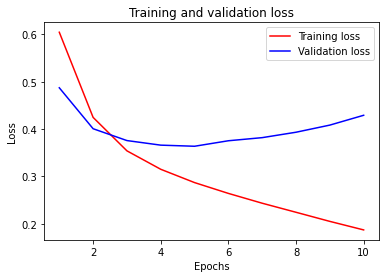

In [41]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 원래 모델과 크게 loss와 accuracy가 차이나지 않음. 오버피팅이 조금 더 늦게 나타나는 정도...?

# 회고

## 이번 프로젝트에서 어려웠던 점

1) 처음에는 구글 코랩에서 진행하였는데, `from konlpy.tag import Mecab`이 진행되지 않았다. JAVA도 설치해 보았으나 진행되지 않아서, 클라우드 주피터로 작성하였다. (아마도 내 컴퓨터가 윈도우라서 여러 설정이 필요한 듯 했다. 아이펠의 클라우드 주피터에서는 리눅스 기반이라 별다른 설정 없이 잘 진행되었다.)

2) **`8)`**에서 **`gensim 버전을 3.x.x로 낮춰야 오류가 나지 않습니다.`**:라는 문구를 보고 gensim 버전을 확인했더니 `4.1`버전으로 확인이 되었다. 그냥 진행했더니 진짜 에러가 너무 나서 진행이 되질 않아서 버전을 낮추는 방법을 찾아보느라 너무 오래걸렸다.

- 다운 그레이드를 했지만 계속 오류가 나서... 아이펠 선배님의 명예의 전당에서 참고하려고 깃허브를 참고했는데 그 분의 회고에서 ***다운 그레이드 관련 이슈와는 상관없는 문제같았다*** 라는 회고를 보고 <u>절망과 분노를 느끼고 눈물을 흘렸다...<br>(진짜 운거 맞음 :( )</u>
- 주말동안 20시간을 투자했지만 결국 **`8)`**에서 진행이 더 되지 않아서 결과도출을 포기할까 고민했다...

3) ***`8)`***에서 깃허브 링크에서 `ko.bin` **<u>파일이 손상된 것 같다.</u>** 안그래도 그동안 수많은 에러와 코드분석으로 많은 시간이 걸렸는데 파일까지 정상이 아니어서... 너무 화가난다...<br>
그리고 같은 폴더 안에 있는 `ko.tsv`파일을 넣어봤으나, 그 안에 라벨링 되어있는 문자가 for문 안에서 걸려서 더 진행되지 않았다. 인코딩 에러라고 떠서 온갖 인코딩을 시도해봤으나 실패. 

<br>

에러 메세지를 자세히 보니
```
277     vocab_size, vector_size = (int(x) for x in header.split())  # throws for invalid file format
278     if limit:
279         vocab_size = min(vocab_size, limit)

ValueError: invalid literal for int() with base 10: '하'
```
<br>
라고 나와있는데, `277` 코드에서 넘어가지 못하고 있는 듯 했다.<br>

근데 이건 <u>내가 작성한 코드가 아니고......................</u><br>

***`load_word2vec_format` 메서드에 내장된 코드인데..........*** <br>

<u>내가 잘못한줄 알고 고민했던 시간이 너무 길었다...........</u><br>

<br>

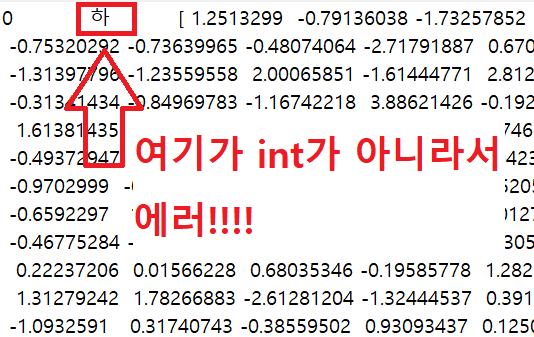
    
<br>

**은지님이 주신 코드로 성공.** <u>하지만 노드에는 없는 코드였으므로***(명예의 전당에서 발견한 코드라고 하셨음)***, 노드를 만들어주신 <span style="color:red">***우지철***</span>님의 ***코드가 잘못되어서*** 고통받은 것이었다</u>

    

## 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

### 1) 함수 load_data

단계별로 나뉘어 있지 않고, 예시코드가 하나의 함수에 모두 들어가 있어서 해석하기도 참 힘들고 오랜 시간이 걸렸다. 그렇다고 내가 새로 코드를 짤 수 있는 실력은 되질 않아서 최선을 다해 주석을 달아가며 힘겹게 코드를 이해했고, 또 아예 학습에 필요한 모든 변수들을 반환할 수 있도록 만들기로 했다. 그래서 시간이 더 배로 오래 걸림... <strike>(그냥 복사 붙여넣기 할걸 괜히 건드려서 지옥을 열어버린 기분이었다...) </strike>

   

### 2) keras에서 모델 쌓는 법

아이펠 이전에 잠깐 AI강의를 들은 적이 있었는데, 그땐 잘 모르고 따라했던 코드가 있어서 다시 봤더니 아이펠의 방식(`model.add()`)과 다르게 모델 레이어를 쌓은 것을 보고 다양한 코드 방식에 익숙해지고 싶어서 시도해 보았다. 

<br>

***이전 강의에서 썼던 코드***

```
# 모델 만들기
X = tf.keras.Input(shape=[28, 28, 1])
H = tf.keras.layers.Conv2D(3, kernel_size=5, activation='swish')(X) # filter (3, 5, 5, 1)
H = tf.keras.layers.Conv2D(6, kernel_size=5, activation='swish')(H) # filter (6, 5, 5, 3)
H = tf.keras.layers.Flatten()(H)
H = tf.keras.layers.Dense(84, activation='swish')(H)
Y = tf.keras.layers.Dense(10, activation='softmax')(H)

model = tf.keras.Model(X, Y)
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

model.summary()
```

<br>

***이번 프로젝트에서 시험해 봄***

```
# 임베딩사이즈는 (1, 10000, 4)이다.
# 단어사전의 갯수 10000개, 단어 하나당 4차원 벡터
# LSTM은 3차원을 입력값으로 받으므로, 3차원 배열로 임베딩 해준다.

E = tf.keras.layers.Embedding(10000, 4, input_shape=(None,))
H = tf.keras.layers.LSTM(8)(E)
H = tf.keras.layers.Dense(8, activation='relu')(H)
Y = tf.keras.layers.Dense(1, activation='sigmoid')(H)  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다

model = tf.keras.Sequential(E, Y)

model.summary()
```

<br>

이렇게 입력하는 것이 계속 오류가 나서 마지막에 `tf.keras.Sequential(Y)`로도 작성해 보았지만 fail...

**tensorflow 공식문서**를 찾아보니 [순차모델의 일반적인 디버깅 워크플로우: add() + summary()](https://www.tensorflow.org/guide/keras/sequential_model?hl=ko#%EC%9D%BC%EB%B0%98%EC%A0%81%EC%9D%B8_%EB%94%94%EB%B2%84%EA%B9%85_%EC%9B%8C%ED%81%AC%ED%94%8C%EB%A1%9C%EC%9A%B0_add_summary)라고 되어 있어서... Sequential 모델에서는 model을 먼저 선언하고, `model.add()`를 써야하는 거구나 납득하게 되었다.

강의를 들었을 때 사용했던 코드는 <u>**이미지 분석 CNN** 관련 코드라서, **글자를 분석하는 Sequencial 모델**과는 다르게 생각하고 적용해야한다는 것을 알게되었다.</u>

### 3) model.summary()가 출력되었을 때 파라미터의 계산

- 예전에 파라미터의 계산에 대해서 배운적이 있었는데 하나도 기억나지 않아서 다시 찾아보고 정리함

<br>

***CNN의 계산***
    
$커널크기 * 입력차원수 * 출력차원수 + bias(출력차원수와 같음)$


<br>

***LSTM의 계산***

$inputdim * ((inputdim+1) * outputdim+outputdim^2)$

- 다른 RNN과 계산식이 다르다
- RNN은 기본적으로 텍스트를 분석하는 **Sequential객체**이기 때문에, **CNN과 달리 이전 레이어에서의 계산식을 모두 고려해야한다!**


<br>

> ❗ <u>**bias 노드란?**</u><br><br>
입력 패턴의 모든 값이 0이면, 가중치가 변하지 않아 모델이 학습을 할 수 없으므로  <u>상수 출력값이 `1`인 **bias 노드**를 가상의 input으로 넣어준다.</u> **(출력 노드의 input이다)**<br>
출력 노드는 가상의 상수 출력 값인 bias노드를 가진다.


### 4) 과적합 문제 (overfitting)

RNN, CNN, GOLD MAX POOLING 세 가지의 모델을 만들어서 학습을 했는데, 파라미터를 아무리 바꿔도 과적합 문제가 해결되지 않았다...<br><br>
***특히 CNN의 경우에는*** 모델 학습할 때 계속 오류가 났는데, **negative dim**이 생겼다는 오류 메세지가 떴고, conv 1D의 커널 사이즈를 7로 두었는데, 메세지를 보니 3에서 7을 빼서 음수가 되었다고 적혀있었다. 임베딩하면서 입력데이터를 3차원 배열로 변환시켰었는데 <u>커널 사이즈가 3보다 커서 학습이 되지 않는것</u>으로 이해하고 3보다 작은 커널사이즈를 입력했더니 학습이 진행되었다.

## 루브릭 평가 지표를 맞추기 위해 시도한 것들

>1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.<br>
        동작됨
    
>2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.<br>
        특수문자 제거, 토크나이저 생성, 패딩처리 모두 완료되었다.
    
> 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.<br>
        학습됨

## 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

    

- ***초보자가 할 수 없는 난이도***
- 처음부터 <u>**모듈**을 설치하는 방법을 찾는데에게 너무 오랜시간이 소요됨</u>
- 앞의 예제에서 코드를 가지고 와도, <u>초보자가 이해하기 어려운 코드</u>였고 조금씩 다르게 설정해야해서 ***엄청난 혼란***이 생겼음
- 마지막에 <u>***gensim***</u>도 계속 에러가 났고, 버전을 다운그레이드하라고 되어있었는데 <u>다운그레이드하는 코드를 알려줬어야 하는것이 아닌가...</u> 심지어는 다운그레이드와는 관련없는 에러이슈인듯해서 더 절망적이다.
- 금토일 주말동안 이 프로젝트에만 **하루 10시간씩을 투자**했으나... 결국은 노드에 없는 코드로 성공.<br> 
***노드를 교과서로 생각하는 아이펠 학생들에게는*** <span style='color:red'>청천벽력</span>같은 소식이라고 생각함. 언동 퍼실님이 보여준 <span style='color:green'>**코드 닌자**</span>를 연상케하는 노드였다.

## 자기 다짐

나는 할만큼 했다